In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
env = MouselabEnv([4,1,2], reward=Normal(0, 1), cost=0)
env.action_features(2)

array([ 1.   ,  0.   ,  0.   ,  0.4  ,  0.966,  2.255])

# Monte-Carlo Approximation of VPI and myopic VOC 
This notebook demonstrates that VPI and myopic VOC can be approximated with reasonable accuracy
and efficiency via sampling.

## VOC

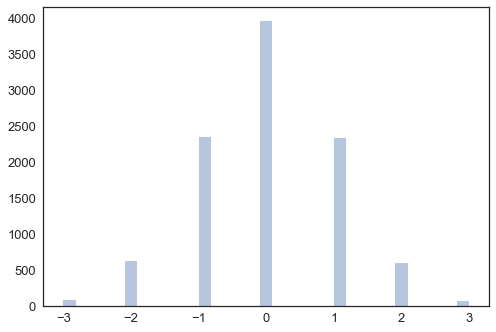

In [3]:
from scipy.stats import norm

def reward(n=7):
    d = norm(0, 1)
    vals = np.linspace(-3, 3, n)
    delta = vals[1] - vals[0]
    bins = np.array((-np.inf, *(vals[1:] - delta/2), np.inf))
    probs = np.diff(d.cdf(bins))
    return Categorical(vals, probs)

sns.distplot(reward().sample(10000), kde=0)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


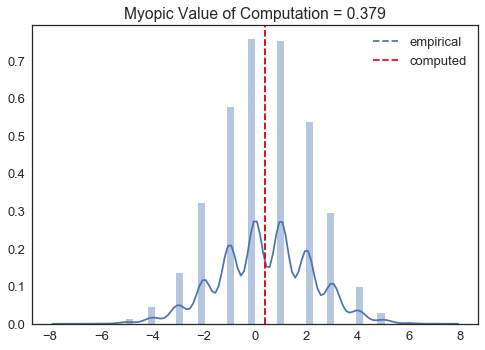

In [7]:
agent = Agent()
env = MouselabEnv([4,1,2], reward=reward(), cost=0)
agent.register(env)
agent.register(FixedPlanPolicy([1, env.term_action]))
voc_computed = env.myopic_voc(1)
voc_empirical = np.array(agent.run_many(10000)['return'])
sns.distplot(voc_empirical)
plt.axvline(np.mean(voc_empirical), ls='--', label='empirical')
plt.axvline(voc_computed, ls='--', c='r', label='computed')
plt.title('Myopic Value of Computation = {:.3f}'.format(voc_computed))
plt.legend()

CPU times: user 495 ms, sys: 6.03 ms, total: 501 ms
Wall time: 501 ms


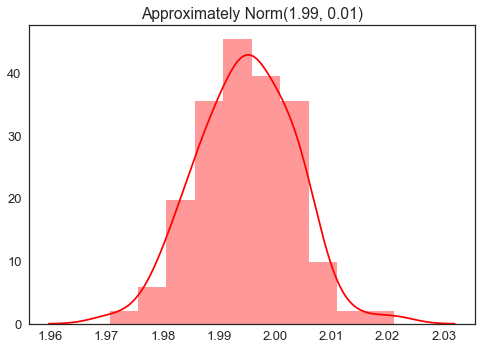

In [3]:
%%time
# How efficient and reliable (low variance) is the approximation?
env.reset()
samples = [env.myopic_voc(1) for _ in range(100)]
sns.distplot(samples, color='r')
plt.title('Approximately {}'.format(Normal.fit(samples)))

## VPI

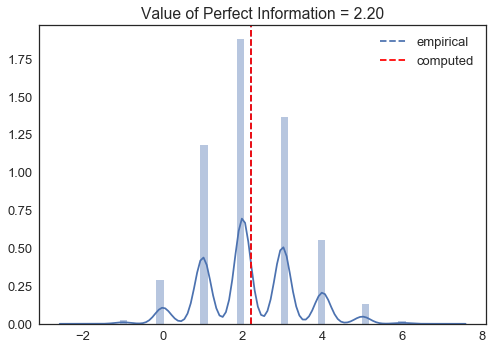

In [175]:
env.reset()
agent.register(FixedPlanPolicy(range(1, env.term_action + 1)))
vpi_computed = env.vpi()
vpi_empirical = agent.run_many(10000)['return']
np.mean(vpi_empirical)
sns.distplot(vpi_empirical)
plt.axvline(np.mean(vpi_empirical), ls='--', label='empirical')
plt.axvline(vpi_computed, ls='--', c='r', label='computed')
plt.title('Value of Perfect Information = {:.2f}'.format(vpi_computed))
plt.legend()

CPU times: user 5.61 s, sys: 39.7 ms, total: 5.65 s
Wall time: 5.79 s


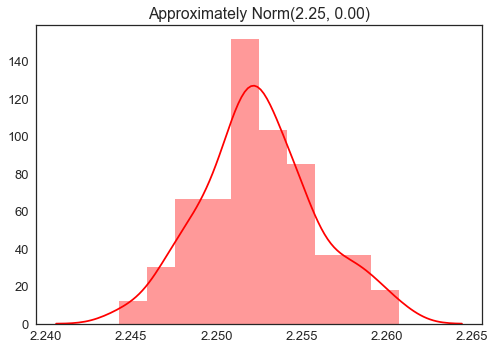

In [87]:
%%time
# How efficient and reliable (low variance) is the approximation?
env.reset()
samples = [env.vpi() for _ in range(100)]
sns.distplot(samples, color='r', label='computed')
plt.title('Approximately {}'.format(Normal.fit(samples)))

## VPI action

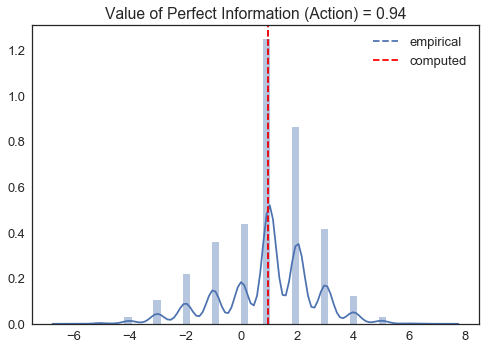

In [176]:
env.reset()
agent.register(FixedPlanPolicy([1,2,3,4,env.term_action]))
vpi_computed = env.node_value_after_observe([1,2,3,4], 0).expectation()
vpi_empirical = agent.run_many(10000)['return']
sns.distplot(vpi_empirical)
plt.axvline(np.mean(vpi_empirical), ls='--', label='empirical')
plt.axvline(vpi_computed, ls='--', c='r', label='computed')
plt.title('Value of Perfect Information (Action) = {:.2f}'.format(vpi_computed))
plt.legend()

## How does it work?
All values are represented as `Distribution` objects, defined in the `distributions.py`.
The `dmax` function returns the distribution of the maximum of two distributions. In the
implementation, this defines a generative model that we can sample from. Given this handy
function, we can write a recursive function that returns a distribution over the expecte value
of a node, given that some number of nodes have been observed. To do this, we take the maximum
of the expectation for unobserved nodes, and the distribution of the maximum for the
nodes to be observed.

```python
    def node_value_after_observe(self, obs, node, state=None):
        """A distribution over the expected value of node, after making an observation.
        
        obs can be a single node, a list of nodes, or 'all'
        """
        state = state if state is not None else self._state

        def r(n):
            if obs == 'all' or n in obs:
                return state[n]  # a distribution or a previously observed value
            else:
                return expectation(state[n])

        return dmax((self.node_value_after_observe(obs, n1, state) + r(n1)
                     for n1 in self.tree[node]),
                    default=PointMass(0))
```

VPI and myopic VOC are straightforward to define given this function; see `meta.py`. 
The plot below shows the value of observing various numbers of nodes. Note that
this is *not* non-myopic VOC because it assumes that all observations are made at once,
while non-myopic VOC determines the second computation based on the outcome of the first.

GenerativeModel for observing all 4:
dmax(add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)), add(dmax(P(0), P(0)), Norm(0.00, 5.00)))


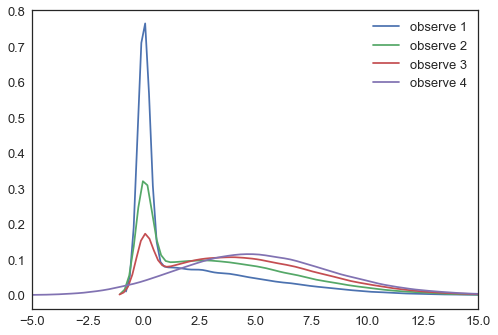

In [6]:
env.reset()
first_four = env.tree[0]
for i in range(1, 5):
    val = env.node_value_after_observe(first_four[:i], 0,)
    sns.distplot(val.sample(100000), hist=0, label='observe {}'.format(i))

plt.xlim(-5, 15)
print('GenerativeModel for observing all 4:\n{}'.format(val))

In [ ]:
# This cell intentionally left blank.
























In [322]:
env = MouselabEnv([4,1,2], reward=reward(100), cost=0)
print('VOC_1: {:.4f}'.format(env.myopic_voc(1)))
print('VPI_full: {:.2f}'.format(env.vpi()))
print('VPI_action: {:.2f}'.format(env.node_value_after_observe([1,2,3,4], 0).expectation()))

def data():
    for n in range(3, 50, 2):
        env = MouselabEnv([4,1,2], reward=reward(n), cost=0)
        yield {
            'VOC_1': env.myopic_voc(1),
            'VPI_full': env.vpi(),
            'VPI_action': env.node_value_after_observe([1,2,3,4], 0).expectation(),
        }
df = pd.DataFrame(data())
df.plot()
plt.xlabel('number of outcomes')
plt.title('Effect of discretization on feature values')

VOC_1: 0.3983
VPI_full: 2.23
VPI_action: 2.37


In [63]:
env = MouselabEnv([2, 2], reward=Categorical([0,1]), cost=0)
def tree(env, s=0):
    return [env._state[s], [tree(env, s1) for s1 in env.tree[s]]]

tree(env)

[0, [[Cat, [[Cat, []], [Cat, []]]], [Cat, [[Cat, []], [Cat, []]]]]]